In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import singletask_dep as st
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'relative'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [15]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6793376202159642 	 Validation loss: 0.6769920769384352 	 
  1%|          | 574/57400 [00:15<38:15, 24.76it/s]
Epoch 2 	 Training loss: 0.6623327399795479 	 Validation loss: 0.6568501611887398 	 
  2%|▏         | 1148/57400 [00:40<37:41, 24.87it/s]
Epoch 3 	 Training loss: 0.6515843809066334 	 Validation loss: 0.650863724239802 	 
  3%|▎         | 1722/57400 [01:06<37:53, 24.49it/s]
Epoch 4 	 Training loss: 0.6448738501254689 	 Validation loss: 0.6443461765677242 	 
  4%|▍         | 2296/57400 [01:31<37:02, 24.79it/s]
Epoch 5 	 Training loss: 0.6387130468564581 	 Validation loss: 0.6377664420564296 	 
  5%|▌         | 2870/57400 [01:57<36:01, 25.23it/s]
Epoch 6 	 Training loss: 0.6318411296460686 	 Validation loss: 0.633036741765879 	 
  6%|▌         | 3444/57400 [02:22<42:37, 21.10it/s]
Epoch 7 	 Training loss: 0.6253506434296067 	 Validation loss: 0.6272286217091447 	 
  7%|▋         | 4018/57400 [02:48<39:45, 22.38it/s]
Epoch 8 	 Training loss: 0.6176963364

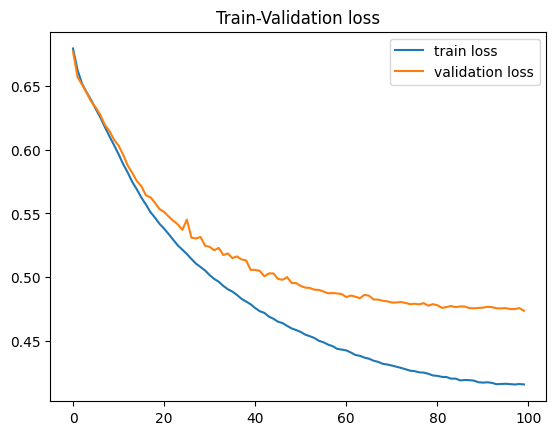

In [15]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7193877551020408, 'precision': 0.7193877551020408, 'f1': 0.7193877551020408, 'accuracy': 0.7193877551020408}
MALE {'recall': 0.7552083333333334, 'precision': 0.7552083333333334, 'f1': 0.7552083333333334, 'accuracy': 0.7552083333333334}
FEMALE {'recall': 0.685, 'precision': 0.685, 'f1': 0.685, 'accuracy': 0.685} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5997474747474747, 'precision': 0.5997474747474747, 'f1': 0.5997474747474747, 'accuracy': 0.5997474747474747}
MALE {'recall': 0.635036496350365, 'precision': 0.635036496350365, 'f1': 0.635036496350365, 'accuracy': 0.635036496350365}
FEMALE {'recall': 0.5616797900262467, 'precision': 0.5616797900262467, 'f1': 0.5616797900262467, 'accuracy': 0.5616797900262467} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5958279009126467, 'precision': 0.5958279009126467, 'f1': 0.5958279009126467, 'accuracy': 0.5958279009126467}
MALE {'recall': 0.623737

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6795872546446864 	 Validation loss: 0.6760812462386439 	 
  1%|          | 574/57400 [00:25<38:24, 24.66it/s]
Epoch 2 	 Training loss: 0.659311437544507 	 Validation loss: 0.659358444860426 	 
  2%|▏         | 1148/57400 [00:51<38:45, 24.19it/s]
Epoch 3 	 Training loss: 0.6462769562359055 	 Validation loss: 0.6497479939864854 	 
  3%|▎         | 1722/57400 [01:16<36:25, 25.47it/s]
Epoch 4 	 Training loss: 0.6384066835513098 	 Validation loss: 0.6432386636734009 	 
  4%|▍         | 2296/57400 [01:42<38:22, 23.94it/s]
Epoch 5 	 Training loss: 0.6318695234712408 	 Validation loss: 0.6420054253885301 	 
  5%|▌         | 2870/57400 [02:08<36:16, 25.05it/s]
Epoch 6 	 Training loss: 0.6252066372578983 	 Validation loss: 0.631941902435432 	 
  6%|▌         | 3444/57400 [02:33<37:38, 23.89it/s]
Epoch 7 	 Training loss: 0.6177258038770032 	 Validation loss: 0.6261796718936855 	 
  7%|▋         | 4018/57400 [02:59<35:32, 25.03it/s]
Epoch 8 	 Training loss: 0.61046577538

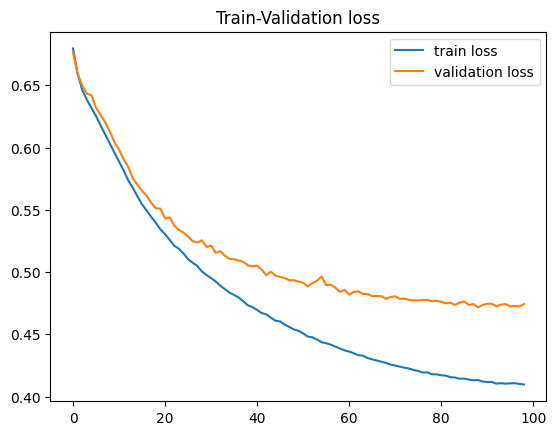

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7423469387755102, 'precision': 0.7423469387755102, 'f1': 0.7423469387755102, 'accuracy': 0.7423469387755102}
MALE {'recall': 0.8515625, 'precision': 0.8515625, 'f1': 0.8515625, 'accuracy': 0.8515625}
FEMALE {'recall': 0.6375, 'precision': 0.6375, 'f1': 0.6375, 'accuracy': 0.6375} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5833333333333334, 'precision': 0.5833333333333334, 'f1': 0.5833333333333334, 'accuracy': 0.5833333333333334}
MALE {'recall': 0.683698296836983, 'precision': 0.683698296836983, 'f1': 0.683698296836983, 'accuracy': 0.683698296836983}
FEMALE {'recall': 0.47506561679790027, 'precision': 0.47506561679790027, 'f1': 0.47506561679790027, 'accuracy': 0.47506561679790027} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.621903520208605, 'precision': 0.621903520208605, 'f1': 0.621903520208605, 'accuracy': 0.621903520208605}
MALE {'recall': 0.7323232323232324, 'precision': 0.73232

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6787023973174211 	 Validation loss: 0.6711595341310663 	 
  1%|          | 574/57400 [00:24<38:21, 24.69it/s]
Epoch 2 	 Training loss: 0.6631330304652556 	 Validation loss: 0.6594664656509788 	 
  2%|▏         | 1148/57400 [00:50<36:31, 25.67it/s]
Epoch 3 	 Training loss: 0.654145989891544 	 Validation loss: 0.6527117278616307 	 
  3%|▎         | 1722/57400 [01:15<36:24, 25.49it/s]
Epoch 4 	 Training loss: 0.6475430016733628 	 Validation loss: 0.6474921955900678 	 
  4%|▍         | 2296/57400 [01:40<36:00, 25.51it/s]
Epoch 5 	 Training loss: 0.6406133227855071 	 Validation loss: 0.6399297572798648 	 
  5%|▌         | 2870/57400 [02:05<34:08, 26.62it/s]
Epoch 6 	 Training loss: 0.6343353352272552 	 Validation loss: 0.6329357947333384 	 
  6%|▌         | 3444/57400 [02:31<34:39, 25.95it/s]
Epoch 7 	 Training loss: 0.6267290627291809 	 Validation loss: 0.6260589906724833 	 
  7%|▋         | 4018/57400 [02:58<51:42, 17.21it/s]
Epoch 8 	 Training loss: 0.619453352

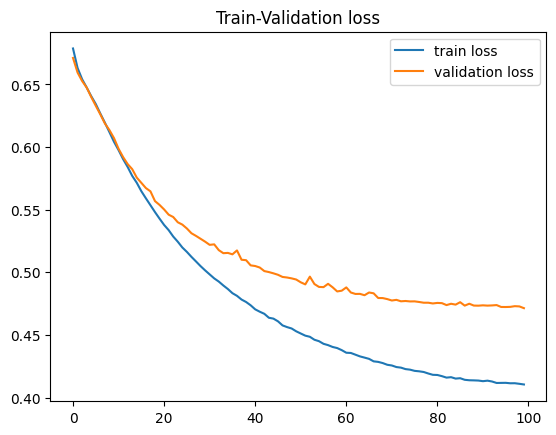

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7206632653061225, 'precision': 0.7206632653061225, 'f1': 0.7206632653061225, 'accuracy': 0.7206632653061225}
MALE {'recall': 0.8046875, 'precision': 0.8046875, 'f1': 0.8046875, 'accuracy': 0.8046875}
FEMALE {'recall': 0.64, 'precision': 0.64, 'f1': 0.64, 'accuracy': 0.64} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5909090909090909, 'precision': 0.5909090909090909, 'f1': 0.5909090909090909, 'accuracy': 0.5909090909090909}
MALE {'recall': 0.6763990267639902, 'precision': 0.6763990267639902, 'f1': 0.6763990267639902, 'accuracy': 0.6763990267639902}
FEMALE {'recall': 0.49868766404199477, 'precision': 0.49868766404199477, 'f1': 0.49868766404199477, 'accuracy': 0.49868766404199477} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6088657105606258, 'precision': 0.6088657105606258, 'f1': 0.6088657105606258, 'accuracy': 0.6088657105606258}
MALE {'recall': 0.6540404040404041, 'precision': 0.65404

In [21]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.7274659863945578, 'precision': 0.7274659863945578, 'f1': 0.7274659863945578, 'accuracy': 0.7274659863945578}
Métricas etiqueta male: {'recall': 0.8038194444444444, 'precision': 0.8038194444444444, 'f1': 0.8038194444444444, 'accuracy': 0.8038194444444444}
Métricas etiqueta female:  {'recall': 0.6541666666666667, 'precision': 0.6541666666666667, 'f1': 0.6541666666666667, 'accuracy': 0.6541666666666667}

 to
Resultado global: {'recall': 0.5913299663299664, 'precision': 0.5913299663299664, 'f1': 0.5913299663299664, 'accuracy': 0.5913299663299664}
Métricas etiqueta male: {'recall': 0.6650446066504461, 'precision': 0.6650446066504461, 'f1': 0.6650446066504461, 'accuracy': 0.6650446066504461}
Métricas etiqueta female:  {'recall': 0.5118110236220472, 'precision': 0.5118110236220472, 'f1': 0.5118110236220472, 'accuracy': 0.5118110236220472}

 as
Resultado global: {'recall': 0.6088657105606258, 'precision': 0.6088657105606258, 'f1': 0.6

## TO

In [13]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933626083962178 	 Validation loss: 0.694391373860634 	 
  1%|          | 574/57400 [00:06<09:39, 98.12it/s]
Epoch 2 	 Training loss: 0.6931582196041267 	 Validation loss: 0.6925076054314435 	 
  2%|▏         | 1148/57400 [00:13<09:21, 100.27it/s]
Epoch 3 	 Training loss: 0.6931882805940581 	 Validation loss: 0.6938204421835431 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:24, 98.58it/s]
Epoch 4 	 Training loss: 0.6931493489999805 	 Validation loss: 0.6921665779614853 	 
  4%|▍         | 2296/57400 [00:25<09:07, 100.62it/s]
Epoch 5 	 Training loss: 0.6931306356337013 	 Validation loss: 0.6926514041625847 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:19, 97.45it/s]
Epoch 6 	 Training loss: 0.6930557736536351 	 Validation loss: 0.6932253776970556 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:37<09:13, 97.54it/s]
Epoch 7 	 Training loss: 0.6931003674812849 	 Validation loss: 0.6929546180417983 	 


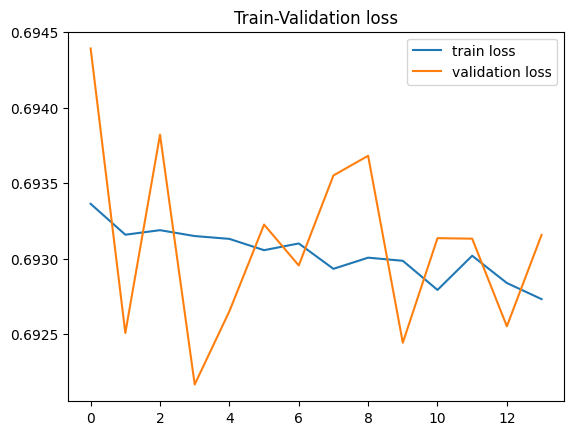

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5025510204081632, 'precision': 0.5025510204081632, 'f1': 0.5025510204081632, 'accuracy': 0.5025510204081632}
MALE {'recall': 0.0390625, 'precision': 0.0390625, 'f1': 0.0390625, 'accuracy': 0.0390625}
FEMALE {'recall': 0.9475, 'precision': 0.9475, 'f1': 0.9475, 'accuracy': 0.9475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4861111111111111, 'precision': 0.4861111111111111, 'f1': 0.4861111111111111, 'accuracy': 0.4861111111111111}
MALE {'recall': 0.029197080291970802, 'precision': 0.029197080291970802, 'f1': 0.029197080291970802, 'accuracy': 0.029197080291970802}
FEMALE {'recall': 0.979002624671916, 'precision': 0.979002624671916, 'f1': 0.979002624671916, 'accuracy': 0.979002624671916} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.48239895697522817, 'accuracy': 0.48239895697522817}
MALE {'recall': 0.03535353535353535, 'precis

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932761463554064 	 Validation loss: 0.6928361058235168 	 
  1%|          | 574/57400 [00:06<09:29, 99.78it/s]
Epoch 2 	 Training loss: 0.6932293811118562 	 Validation loss: 0.6939531989016775 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:29, 98.86it/s]
Epoch 3 	 Training loss: 0.69315911388148 	 Validation loss: 0.6925554699816946 	 
  3%|▎         | 1722/57400 [00:18<09:29, 97.84it/s]
Epoch 4 	 Training loss: 0.6931741114069776 	 Validation loss: 0.6928463780273826 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:15, 99.27it/s]
Epoch 5 	 Training loss: 0.6931594193812447 	 Validation loss: 0.6924366142790196 	 
  5%|▌         | 2870/57400 [00:31<09:14, 98.29it/s]
Epoch 6 	 Training loss: 0.6931012698582241 	 Validation loss: 0.6938101689694292 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:59, 100.00it/s]
Epoch 7 	 Training loss: 0.6930217705537218 	 Validation loss: 0.6927652146856663 	 

2

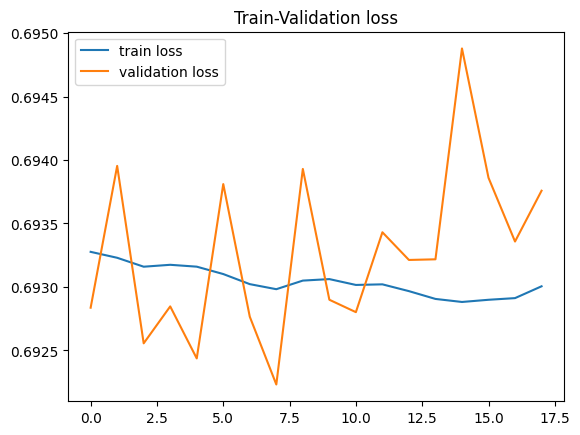

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5038265306122449, 'precision': 0.5038265306122449, 'f1': 0.5038265306122449, 'accuracy': 0.5038265306122449}
MALE {'recall': 0.033854166666666664, 'precision': 0.033854166666666664, 'f1': 0.033854166666666664, 'accuracy': 0.033854166666666664}
FEMALE {'recall': 0.955, 'precision': 0.955, 'f1': 0.955, 'accuracy': 0.955} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.476010101010101, 'precision': 0.476010101010101, 'f1': 0.476010101010101, 'accuracy': 0.476010101010101}
MALE {'recall': 0.019464720194647202, 'precision': 0.019464720194647202, 'f1': 0.019464720194647202, 'accuracy': 0.019464720194647202}
FEMALE {'recall': 0.968503937007874, 'precision': 0.968503937007874, 'f1': 0.968503937007874, 'accuracy': 0.968503937007874} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4863102998696219, 'precision': 0.4863102998696219, 'f1': 0.4863102998696219, 'accuracy': 0.4863102998696219}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693309541363334 	 Validation loss: 0.6917874297853244 	 
  1%|          | 574/57400 [00:06<09:49, 96.47it/s]
Epoch 2 	 Training loss: 0.693202412917639 	 Validation loss: 0.6928898126392041 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:12, 101.83it/s]
Epoch 3 	 Training loss: 0.6931550018878764 	 Validation loss: 0.6924631231922215 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:24, 98.55it/s]
Epoch 4 	 Training loss: 0.6932027584999696 	 Validation loss: 0.6934467149993121 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:05, 101.08it/s]
Epoch 5 	 Training loss: 0.6931177810717127 	 Validation loss: 0.6929031428644212 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:58, 101.27it/s]
Epoch 6 	 Training loss: 0.6930554869490634 	 Validation loss: 0.6944063760466495 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:55, 100.72it/s]
Epoch 7 	 Training loss: 0

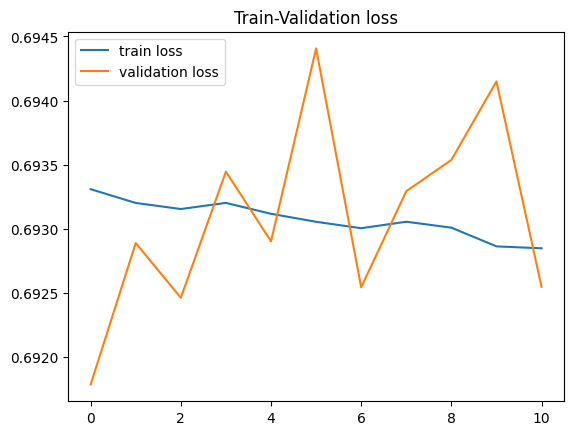

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5089285714285714, 'precision': 0.5089285714285714, 'f1': 0.5089285714285714, 'accuracy': 0.5089285714285714}
MALE {'recall': 0.005208333333333333, 'precision': 0.005208333333333333, 'f1': 0.005208333333333333, 'accuracy': 0.005208333333333333}
FEMALE {'recall': 0.9925, 'precision': 0.9925, 'f1': 0.9925, 'accuracy': 0.9925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47853535353535354, 'precision': 0.47853535353535354, 'f1': 0.47853535353535354, 'accuracy': 0.47853535353535354}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 0.994750656167979, 'precision': 0.994750656167979, 'f1': 0.994750656167979, 'accuracy': 0.994750656167979} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.48239895697522817, 'accuracy': 0.48239895697522817}
MALE {'recall': 0.012626262626262626, 'precision': 0.01262626262

In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5051020408163265, 'precision': 0.5051020408163265, 'f1': 0.5051020408163265, 'accuracy': 0.5051020408163265}
Métricas etiqueta male: {'recall': 0.026041666666666664, 'precision': 0.026041666666666664, 'f1': 0.026041666666666664, 'accuracy': 0.026041666666666664}
Métricas etiqueta female:  {'recall': 0.965, 'precision': 0.965, 'f1': 0.965, 'accuracy': 0.965}

 to
Resultado global: {'recall': 0.4802188552188552, 'precision': 0.4802188552188552, 'f1': 0.4802188552188552, 'accuracy': 0.4802188552188552}
Métricas etiqueta male: {'recall': 0.016220600162206, 'precision': 0.016220600162206, 'f1': 0.016220600162206, 'accuracy': 0.016220600162206}
Métricas etiqueta female:  {'recall': 0.9807524059492563, 'precision': 0.9807524059492563, 'f1': 0.9807524059492563, 'accuracy': 0.9807524059492563}

 as
Resultado global: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002

# AS

In [23]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932124480968569 	 Validation loss: 0.6927735209465027 	 
  1%|          | 574/57400 [00:06<09:38, 98.16it/s]
Epoch 2 	 Training loss: 0.6932459425843136 	 Validation loss: 0.6929654782101259 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:25, 99.43it/s]
Epoch 3 	 Training loss: 0.6930799977496941 	 Validation loss: 0.6914596810179242 	 
  3%|▎         | 1722/57400 [00:18<09:13, 100.53it/s]
Epoch 4 	 Training loss: 0.6931669172094259 	 Validation loss: 0.6938109569630381 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:13, 99.58it/s]
Epoch 5 	 Training loss: 0.6929822415632654 	 Validation loss: 0.6939208628767628 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:53, 102.14it/s]
Epoch 6 	 Training loss: 0.6930926690325919 	 Validation loss: 0.6930589989080267 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:58, 100.22it/s]
Epoch 7 	 Training loss: 0.6929851476531411 	 Validati

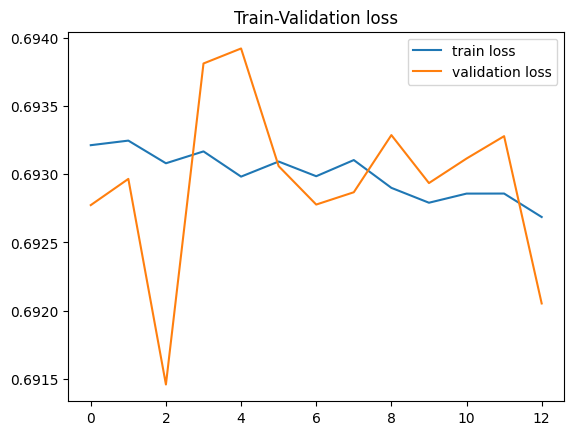

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 0.995, 'precision': 0.995, 'f1': 0.995, 'accuracy': 0.995} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4823232323232323, 'precision': 0.4823232323232323, 'f1': 0.4823232323232323, 'accuracy': 0.4823232323232323}
MALE {'recall': 0.0072992700729927005, 'precision': 0.0072992700729927005, 'f1': 0.0072992700729927005, 'accuracy': 0.0072992700729927005}
FEMALE {'recall': 0.994750656167979, 'precision': 0.994750656167979, 'f1': 0.994750656167979, 'accuracy': 0.994750656167979} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMAL

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932980507508387 	 Validation loss: 0.6921236312995522 	 
  1%|          | 574/57400 [00:06<09:33, 99.14it/s]
Epoch 2 	 Training loss: 0.6932804492084822 	 Validation loss: 0.6929325552309974 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:18, 100.72it/s]
Epoch 3 	 Training loss: 0.6931845947632806 	 Validation loss: 0.6932003871869232 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:22, 98.95it/s]
Epoch 4 	 Training loss: 0.6931222912949552 	 Validation loss: 0.6925778974921016 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:11, 99.91it/s]
Epoch 5 	 Training loss: 0.693029367238387 	 Validation loss: 0.6933925778178845 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:31<09:12, 98.69it/s]
Epoch 6 	 Training loss: 0.6930562947269931 	 Validation loss: 0.6934727652598236 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:56, 100.57it/s]
Epoch 7 	 Training loss: 0.

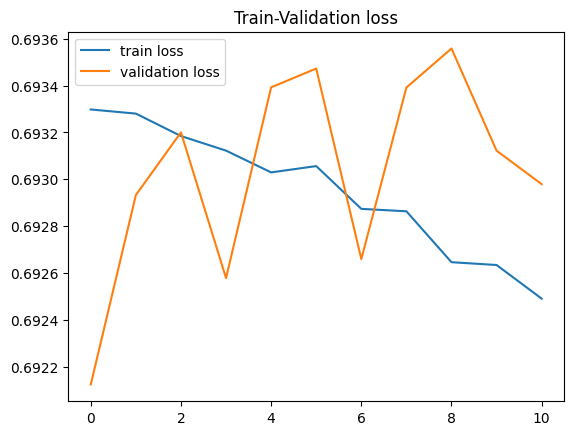

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.514030612244898, 'precision': 0.514030612244898, 'f1': 0.514030612244898, 'accuracy': 0.514030612244898}
MALE {'recall': 0.028645833333333332, 'precision': 0.028645833333333332, 'f1': 0.028645833333333332, 'accuracy': 0.028645833333333332}
FEMALE {'recall': 0.98, 'precision': 0.98, 'f1': 0.98, 'accuracy': 0.98} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4772727272727273, 'precision': 0.4772727272727273, 'f1': 0.4772727272727273, 'accuracy': 0.4772727272727273}
MALE {'recall': 0.009732360097323601, 'precision': 0.009732360097323601, 'f1': 0.009732360097323601, 'accuracy': 0.009732360097323601}
FEMALE {'recall': 0.9816272965879265, 'precision': 0.9816272965879265, 'f1': 0.9816272965879265, 'accuracy': 0.9816272965879265} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4863102998696219, 'precision': 0.4863102998696219, 'f1': 0.4863102998696219, 'accuracy': 0.4863102998696219}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934104550383232 	 Validation loss: 0.6938322024830317 	 
  1%|          | 574/57400 [00:06<09:48, 96.54it/s]
Epoch 2 	 Training loss: 0.693302393478799 	 Validation loss: 0.6920278112767106 	 
  2%|▏         | 1148/57400 [00:12<09:21, 100.17it/s]
Epoch 3 	 Training loss: 0.693133958540727 	 Validation loss: 0.6937172069387921 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:19<09:20, 99.32it/s]
Epoch 4 	 Training loss: 0.6930803850760443 	 Validation loss: 0.6921636967335717 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:25<09:14, 99.31it/s]
Epoch 5 	 Training loss: 0.6930658500576684 	 Validation loss: 0.6928312485500917 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:31<08:57, 101.38it/s]
Epoch 6 	 Training loss: 0.693073998967945 	 Validation loss: 0.6931696857436228 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:59, 100.00it/s]
Epoch 7 	 Training loss: 0.6930093392470157 	 Validation 

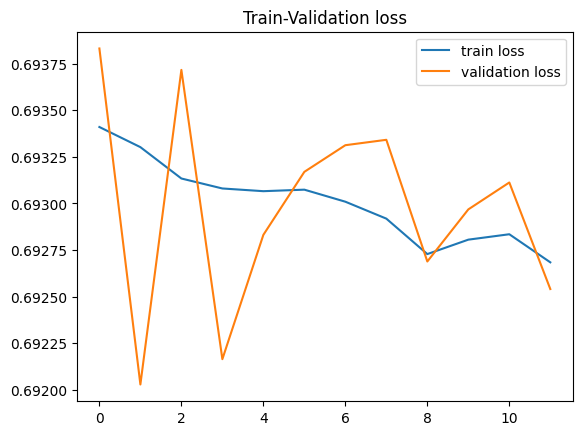

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5038265306122449, 'precision': 0.5038265306122449, 'f1': 0.5038265306122449, 'accuracy': 0.5038265306122449}
MALE {'recall': 0.020833333333333332, 'precision': 0.020833333333333332, 'f1': 0.020833333333333332, 'accuracy': 0.020833333333333332}
FEMALE {'recall': 0.9675, 'precision': 0.9675, 'f1': 0.9675, 'accuracy': 0.9675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.476010101010101, 'precision': 0.476010101010101, 'f1': 0.476010101010101, 'accuracy': 0.476010101010101}
MALE {'recall': 0.029197080291970802, 'precision': 0.029197080291970802, 'f1': 0.029197080291970802, 'accuracy': 0.029197080291970802}
FEMALE {'recall': 0.958005249343832, 'precision': 0.958005249343832, 'f1': 0.958005249343832, 'accuracy': 0.958005249343832} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49022164276401564, 'precision': 0.49022164276401564, 'f1': 0.49022164276401564, 'accuracy': 0.49022164276401564}
MALE

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5085034013605443, 'precision': 0.5085034013605443, 'f1': 0.5085034013605443, 'accuracy': 0.5085034013605443}
Métricas etiqueta male: {'recall': 0.016493055555555556, 'precision': 0.016493055555555556, 'f1': 0.016493055555555556, 'accuracy': 0.016493055555555556}
Métricas etiqueta female:  {'recall': 0.9808333333333333, 'precision': 0.9808333333333333, 'f1': 0.9808333333333333, 'accuracy': 0.9808333333333333}

 to
Resultado global: {'recall': 0.47853535353535354, 'precision': 0.47853535353535354, 'f1': 0.47853535353535354, 'accuracy': 0.47853535353535354}
Métricas etiqueta male: {'recall': 0.0154095701540957, 'precision': 0.0154095701540957, 'f1': 0.0154095701540957, 'accuracy': 0.0154095701540957}
Métricas etiqueta female:  {'recall': 0.9781277340332458, 'precision': 0.9781277340332458, 'f1': 0.9781277340332458, 'accuracy': 0.9781277340332458}

 as
Resultado global: {'recall': 0.48587570621468923, 'precision': 0.48587570621468

# Pruebas hiperparámetros 2

In [31]:
emb_dim = 20
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 64

## ABOUT

In [32]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6810072089321522 	 Validation loss: 0.6823746248827143 	 
  1%|          | 574/57400 [00:04<06:38, 142.69it/s]
Epoch 2 	 Training loss: 0.6755603629745257 	 Validation loss: 0.6694295376034106 	 
  2%|▏         | 1148/57400 [00:08<06:41, 140.20it/s]
Epoch 3 	 Training loss: 0.658058668366708 	 Validation loss: 0.6542424458568379 	 
  3%|▎         | 1722/57400 [00:12<06:32, 141.91it/s]
Epoch 4 	 Training loss: 0.6468192133338609 	 Validation loss: 0.6453940009666701 	 
  4%|▍         | 2296/57400 [00:17<06:22, 143.96it/s]
Epoch 5 	 Training loss: 0.6391837350790509 	 Validation loss: 0.6405056603884293 	 
  5%|▌         | 2870/57400 [00:21<06:21, 142.82it/s]
Epoch 6 	 Training loss: 0.6322194224658328 	 Validation loss: 0.6355600912692183 	 
  6%|▌         | 3444/57400 [00:25<06:20, 141.64it/s]
Epoch 7 	 Training loss: 0.6259098880590047 	 Validation loss: 0.6285401764562575 	 
  7%|▋         | 4018/57400 [00:30<06:20, 140.12it/s]
Epoch 8 	 Training loss: 0.61

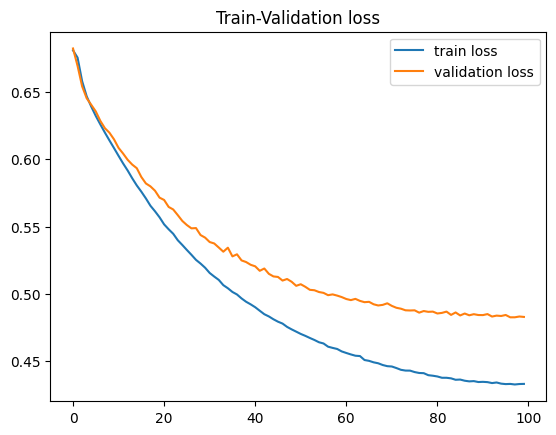

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7168367346938775, 'precision': 0.7168367346938775, 'f1': 0.7168367346938774, 'accuracy': 0.7168367346938775}
MALE {'recall': 0.7994791666666666, 'precision': 0.7994791666666666, 'f1': 0.7994791666666666, 'accuracy': 0.7994791666666666}
FEMALE {'recall': 0.6375, 'precision': 0.6375, 'f1': 0.6375, 'accuracy': 0.6375} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5744949494949495, 'precision': 0.5744949494949495, 'f1': 0.5744949494949495, 'accuracy': 0.5744949494949495}
MALE {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}
FEMALE {'recall': 0.47506561679790027, 'precision': 0.47506561679790027, 'f1': 0.47506561679790027, 'accuracy': 0.47506561679790027} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5840938722294654, 'precision': 0.5840938722294654, 'f1': 0.5840938722294654, 'accuracy': 0.5840938722294654}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6810280146914492 	 Validation loss: 0.6823869994131185 	 
  1%|          | 574/57400 [00:04<06:33, 144.34it/s]
Epoch 2 	 Training loss: 0.6771365385437677 	 Validation loss: 0.6753727480516596 	 
  2%|▏         | 1148/57400 [00:08<06:32, 143.46it/s]
Epoch 3 	 Training loss: 0.6651978138639536 	 Validation loss: 0.6572434649629108 	 
  3%|▎         | 1722/57400 [00:12<06:31, 142.22it/s]
Epoch 4 	 Training loss: 0.6528259406729442 	 Validation loss: 0.6467218106075868 	 
  4%|▍         | 2296/57400 [00:17<06:30, 141.17it/s]
Epoch 5 	 Training loss: 0.6448631233662263 	 Validation loss: 0.6409949498661494 	 
  5%|▌         | 2870/57400 [00:21<06:22, 142.54it/s]
Epoch 6 	 Training loss: 0.637292913755058 	 Validation loss: 0.633977374788058 	 
  6%|▌         | 3444/57400 [00:25<06:21, 141.47it/s]
Epoch 7 	 Training loss: 0.6302439975406234 	 Validation loss: 0.6288889515197883 	 
  7%|▋         | 4018/57400 [00:30<06:13, 143.01it/s]
Epoch 8 	 Training loss: 0.623

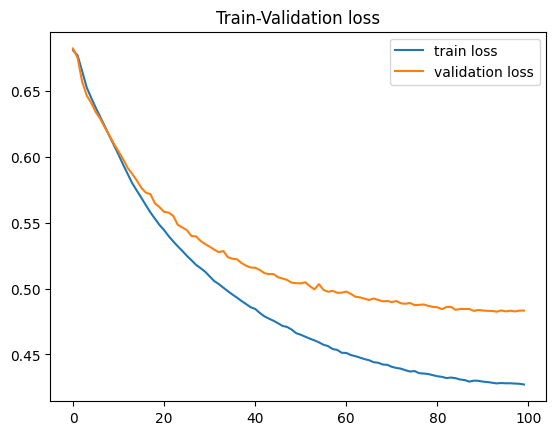

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7142857142857143, 'precision': 0.7142857142857143, 'f1': 0.7142857142857143, 'accuracy': 0.7142857142857143}
MALE {'recall': 0.8203125, 'precision': 0.8203125, 'f1': 0.8203125, 'accuracy': 0.8203125}
FEMALE {'recall': 0.6125, 'precision': 0.6125, 'f1': 0.6125, 'accuracy': 0.6125} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5934343434343434, 'precision': 0.5934343434343434, 'f1': 0.5934343434343434, 'accuracy': 0.5934343434343434}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.46981627296587924, 'precision': 0.46981627296587924, 'f1': 0.46981627296587924, 'accuracy': 0.46981627296587924} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5723598435462842, 'precision': 0.5723598435462842, 'f1': 0.5723598435462842, 'accuracy': 0.5723598435462842}
MALE {'recall': 0.6843434343434344, 'precision': 0.6

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6807026791447962 	 Validation loss: 0.6815517999358096 	 
  1%|          | 574/57400 [00:04<06:34, 144.07it/s]
Epoch 2 	 Training loss: 0.6745753419108507 	 Validation loss: 0.6682817986456014 	 
  2%|▏         | 1148/57400 [00:08<06:39, 140.65it/s]
Epoch 3 	 Training loss: 0.6580739960022505 	 Validation loss: 0.6576077089471332 	 
  3%|▎         | 1722/57400 [00:12<06:27, 143.73it/s]
Epoch 4 	 Training loss: 0.6500419047028345 	 Validation loss: 0.6525879583116305 	 
  4%|▍         | 2296/57400 [00:17<06:24, 143.40it/s]
Epoch 5 	 Training loss: 0.6433573587430894 	 Validation loss: 0.6477767592769558 	 
  5%|▌         | 2870/57400 [00:21<06:18, 144.17it/s]
Epoch 6 	 Training loss: 0.6368220014439228 	 Validation loss: 0.643313537209721 	 
  6%|▌         | 3444/57400 [00:25<06:16, 143.25it/s]
Epoch 7 	 Training loss: 0.630485416912451 	 Validation loss: 0.634255872944654 	 
  7%|▋         | 4018/57400 [00:30<06:17, 141.36it/s]
Epoch 8 	 Training loss: 0.6240

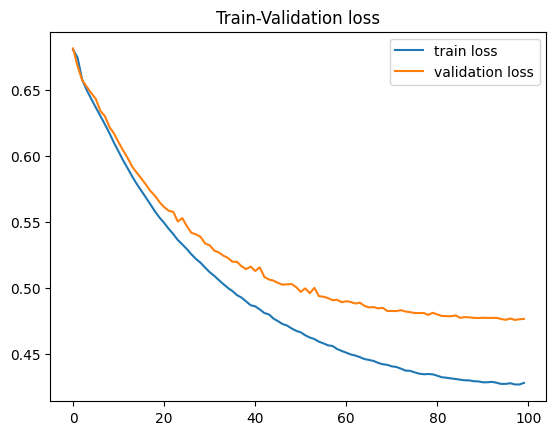

In [37]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [38]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7219387755102041, 'precision': 0.7219387755102041, 'f1': 0.7219387755102041, 'accuracy': 0.7219387755102041}
MALE {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}
FEMALE {'recall': 0.6, 'precision': 0.6, 'f1': 0.6, 'accuracy': 0.6} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6060606060606061, 'precision': 0.6060606060606061, 'f1': 0.6060606060606061, 'accuracy': 0.6060606060606061}
MALE {'recall': 0.7347931873479319, 'precision': 0.7347931873479319, 'f1': 0.7347931873479319, 'accuracy': 0.7347931873479319}
FEMALE {'recall': 0.4671916010498688, 'precision': 0.4671916010498688, 'f1': 0.4671916010498688, 'accuracy': 0.4671916010498688} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5997392438070405, 'precision': 0.5997392438070405, 'f1': 0.5997392438070405, 'accuracy': 0.5997392438070405}
MALE {'recall': 0.7020202020

In [39]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.717687074829932, 'precision': 0.717687074829932, 'f1': 0.717687074829932, 'accuracy': 0.717687074829932}
Métricas etiqueta male: {'recall': 0.8229166666666666, 'precision': 0.8229166666666666, 'f1': 0.8229166666666666, 'accuracy': 0.8229166666666666}
Métricas etiqueta female:  {'recall': 0.6166666666666667, 'precision': 0.6166666666666667, 'f1': 0.6166666666666667, 'accuracy': 0.6166666666666667}

 to
Resultado global: {'recall': 0.5913299663299664, 'precision': 0.5913299663299664, 'f1': 0.5913299663299664, 'accuracy': 0.5913299663299664}
Métricas etiqueta male: {'recall': 0.7031630170316302, 'precision': 0.7031630170316302, 'f1': 0.7031630170316302, 'accuracy': 0.7031630170316302}
Métricas etiqueta female:  {'recall': 0.47069116360454943, 'precision': 0.47069116360454943, 'f1': 0.47069116360454943, 'accuracy': 0.47069116360454943}

 as
Resultado global: {'recall': 0.5853976531942634, 'precision': 0.5853976531942634, 'f1': 0.5

## TO

In [40]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932390095464859 	 Validation loss: 0.6928484429747371 	 
  1%|          | 574/57400 [00:05<07:41, 123.25it/s]
Epoch 2 	 Training loss: 0.6931505102521451 	 Validation loss: 0.693317445658021 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:10<07:46, 120.61it/s]
Epoch 3 	 Training loss: 0.693173420346157 	 Validation loss: 0.6932311916755418 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:37, 121.72it/s]
Epoch 4 	 Training loss: 0.6931434319409759 	 Validation loss: 0.6926792203369787 	 
  4%|▍         | 2296/57400 [00:20<07:34, 121.33it/s]
Epoch 5 	 Training loss: 0.6930749827561062 	 Validation loss: 0.6933486643484084 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:27, 121.91it/s]
Epoch 6 	 Training loss: 0.6931527017093286 	 Validation loss: 0.6928283410557246 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:20, 122.52it/s]
Epoch 7 	 Training loss: 0.6930673612534792 	 Validat

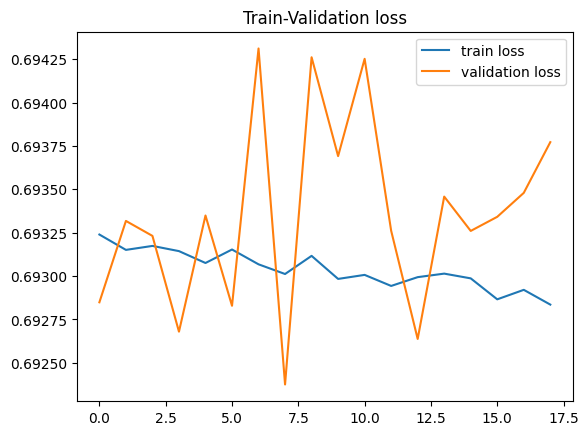

In [41]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [42]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.47831632653061223, 'precision': 0.47831632653061223, 'f1': 0.47831632653061223, 'accuracy': 0.47831632653061223}
MALE {'recall': 0.265625, 'precision': 0.265625, 'f1': 0.265625, 'accuracy': 0.265625}
FEMALE {'recall': 0.6825, 'precision': 0.6825, 'f1': 0.6825, 'accuracy': 0.6825} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
MALE {'recall': 0.31143552311435524, 'precision': 0.31143552311435524, 'f1': 0.31143552311435524, 'accuracy': 0.31143552311435524}
FEMALE {'recall': 0.6824146981627297, 'precision': 0.6824146981627297, 'f1': 0.6824146981627297, 'accuracy': 0.6824146981627297} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4758800521512386, 'precision': 0.4758800521512386, 'f1': 0.4758800521512386, 'accuracy': 0.4758800521512386}
MALE {'recall': 0.2702020202020202, 'precision':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933085687899839 	 Validation loss: 0.6925974074056593 	 
  1%|          | 574/57400 [00:05<07:43, 122.60it/s]
Epoch 2 	 Training loss: 0.6932836562291255 	 Validation loss: 0.6934444267871016 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:10<07:41, 121.99it/s]
Epoch 3 	 Training loss: 0.6931666089059584 	 Validation loss: 0.6926465307251882 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:36, 121.91it/s]
Epoch 4 	 Training loss: 0.6931877416600749 	 Validation loss: 0.6929411625458022 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:25, 123.60it/s]
Epoch 5 	 Training loss: 0.6930465342068091 	 Validation loss: 0.6926355533680674 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:23, 122.84it/s]
Epoch 6 	 Training loss: 0.6930891860029839 	 Validation loss: 0.6923548215526646 	 
  6%|▌         | 3444/57400 [00:30<07:21, 122.34it/s]
Epoch 7 	 Training loss: 0.6931197582013932 	 Valid

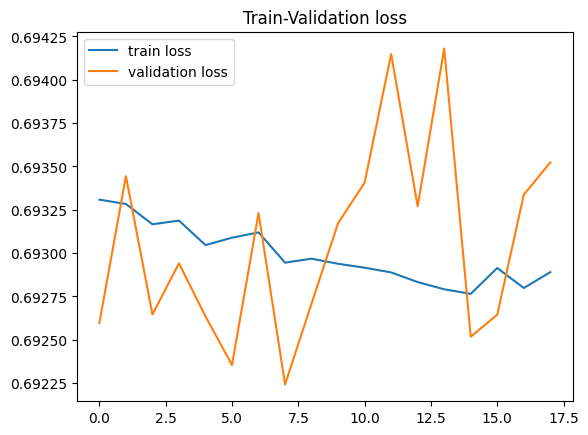

In [43]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [44]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5025510204081632, 'precision': 0.5025510204081632, 'f1': 0.5025510204081632, 'accuracy': 0.5025510204081632}
MALE {'recall': 0.03125, 'precision': 0.03125, 'f1': 0.03125, 'accuracy': 0.03125}
FEMALE {'recall': 0.955, 'precision': 0.955, 'f1': 0.955, 'accuracy': 0.955} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48863636363636365, 'precision': 0.48863636363636365, 'f1': 0.48863636363636365, 'accuracy': 0.48863636363636365}
MALE {'recall': 0.031630170316301706, 'precision': 0.031630170316301706, 'f1': 0.031630170316301706, 'accuracy': 0.031630170316301706}
FEMALE {'recall': 0.9816272965879265, 'precision': 0.9816272965879265, 'f1': 0.9816272965879265, 'accuracy': 0.9816272965879265} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4771838331160365, 'precision': 0.4771838331160365, 'f1': 0.4771838331160365, 'accuracy': 0.4771838331160365}
MALE {'recall': 0.017676767676767676, 'precision': 0

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933245841634398 	 Validation loss: 0.6933139946501133 	 
  1%|          | 574/57400 [00:05<07:42, 122.84it/s]
Epoch 2 	 Training loss: 0.6931930347394445 	 Validation loss: 0.6931431232872656 	 
  2%|▏         | 1148/57400 [00:10<07:36, 123.29it/s]
Epoch 3 	 Training loss: 0.6931791859013694 	 Validation loss: 0.6928397235223802 	 
  3%|▎         | 1722/57400 [00:15<07:32, 123.12it/s]
Epoch 4 	 Training loss: 0.6931585926004403 	 Validation loss: 0.6934794611850027 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:34, 121.18it/s]
Epoch 5 	 Training loss: 0.6931473296070764 	 Validation loss: 0.6937213034953101 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:26, 122.00it/s]
Epoch 6 	 Training loss: 0.6931907249036982 	 Validation loss: 0.692896171141479 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:23, 121.64it/s]
Epoch 7 	 Training loss: 0.6930647885965553 	 Validation loss: 0.6934068465636949

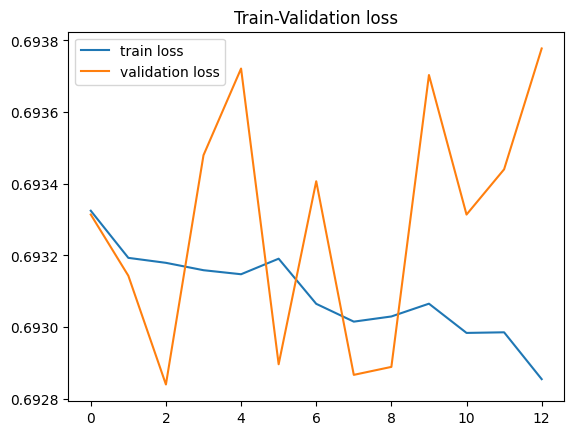

In [45]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [46]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4987244897959184, 'precision': 0.4987244897959184, 'f1': 0.4987244897959184, 'accuracy': 0.4987244897959184}
MALE {'recall': 0.028645833333333332, 'precision': 0.028645833333333332, 'f1': 0.028645833333333332, 'accuracy': 0.028645833333333332}
FEMALE {'recall': 0.95, 'precision': 0.95, 'f1': 0.9500000000000001, 'accuracy': 0.95} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4684343434343434, 'precision': 0.4684343434343434, 'f1': 0.4684343434343434, 'accuracy': 0.4684343434343434}
MALE {'recall': 0.0340632603406326, 'precision': 0.0340632603406326, 'f1': 0.0340632603406326, 'accuracy': 0.0340632603406326}
FEMALE {'recall': 0.937007874015748, 'precision': 0.937007874015748, 'f1': 0.9370078740157481, 'accuracy': 0.937007874015748} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE 

In [47]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4931972789115646, 'precision': 0.4931972789115646, 'f1': 0.4931972789115646, 'accuracy': 0.4931972789115646}
Métricas etiqueta male: {'recall': 0.10850694444444445, 'precision': 0.10850694444444445, 'f1': 0.10850694444444445, 'accuracy': 0.10850694444444445}
Métricas etiqueta female:  {'recall': 0.8624999999999999, 'precision': 0.8624999999999999, 'f1': 0.8625, 'accuracy': 0.8624999999999999}

 to
Resultado global: {'recall': 0.4823232323232323, 'precision': 0.4823232323232323, 'f1': 0.4823232323232323, 'accuracy': 0.4823232323232323}
Métricas etiqueta male: {'recall': 0.12570965125709652, 'precision': 0.12570965125709652, 'f1': 0.12570965125709652, 'accuracy': 0.12570965125709652}
Métricas etiqueta female:  {'recall': 0.8670166229221348, 'precision': 0.8670166229221348, 'f1': 0.8670166229221348, 'accuracy': 0.8670166229221348}

 as
Resultado global: {'recall': 0.47805302042590175, 'precision': 0.47805302042590175, 'f1': 0.478

## AS

In [48]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932866817359725 	 Validation loss: 0.6933898097377712 	 
  1%|          | 574/57400 [00:05<07:47, 121.62it/s]
Epoch 2 	 Training loss: 0.6932141172345923 	 Validation loss: 0.6939498822567827 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:10<07:38, 122.79it/s]
Epoch 3 	 Training loss: 0.6931367646318695 	 Validation loss: 0.6929056775771966 	 
  3%|▎         | 1722/57400 [00:15<07:45, 119.52it/s]
Epoch 4 	 Training loss: 0.6931943636945731 	 Validation loss: 0.6930040888867136 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:28, 122.78it/s]
Epoch 5 	 Training loss: 0.6931021993376236 	 Validation loss: 0.6927843821250786 	 
  5%|▌         | 2870/57400 [00:25<07:21, 123.50it/s]
Epoch 6 	 Training loss: 0.6930481763459249 	 Validation loss: 0.693228505425534 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:24, 121.48it/s]
Epoch 7 	 Training loss: 0.6929314050317226 	 Validation loss: 0.6934543251991272

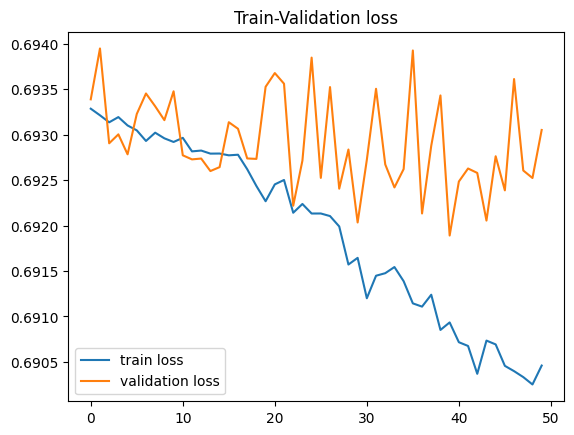

In [49]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [50]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5433673469387755, 'precision': 0.5433673469387755, 'f1': 0.5433673469387755, 'accuracy': 0.5433673469387755}
MALE {'recall': 0.6119791666666666, 'precision': 0.6119791666666666, 'f1': 0.6119791666666666, 'accuracy': 0.6119791666666666}
FEMALE {'recall': 0.4775, 'precision': 0.4775, 'f1': 0.4775, 'accuracy': 0.4775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5606060606060606, 'precision': 0.5606060606060606, 'f1': 0.5606060606060606, 'accuracy': 0.5606060606060606}
MALE {'recall': 0.5742092457420924, 'precision': 0.5742092457420924, 'f1': 0.5742092457420924, 'accuracy': 0.5742092457420924}
FEMALE {'recall': 0.5459317585301837, 'precision': 0.5459317585301837, 'f1': 0.5459317585301837, 'accuracy': 0.5459317585301837} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5501955671447197, 'precision': 0.5501955671447197, 'f1': 0.5501955671447197, 'accuracy': 0.5501955671447197}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931805868182033 	 Validation loss: 0.6933124408883563 	 
  1%|          | 574/57400 [00:05<07:46, 121.86it/s]
Epoch 2 	 Training loss: 0.6931581001871554 	 Validation loss: 0.6927479545948869 	 
  2%|▏         | 1148/57400 [00:10<07:41, 121.87it/s]
Epoch 3 	 Training loss: 0.6931727786097377 	 Validation loss: 0.6939478678218389 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:42, 120.28it/s]
Epoch 4 	 Training loss: 0.6932042070797512 	 Validation loss: 0.6934147578174785 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:20<07:28, 122.82it/s]
Epoch 5 	 Training loss: 0.6930513760977091 	 Validation loss: 0.6936367729962882 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:21, 123.61it/s]
Epoch 6 	 Training loss: 0.6929582088458829 	 Validation loss: 0.6926521032543506 	 
  6%|▌         | 3444/57400 [00:30<07:20, 122.36it/s]
Epoch 7 	 Training loss: 0.6930960558017372 	 Validation loss: 0.692663786774974

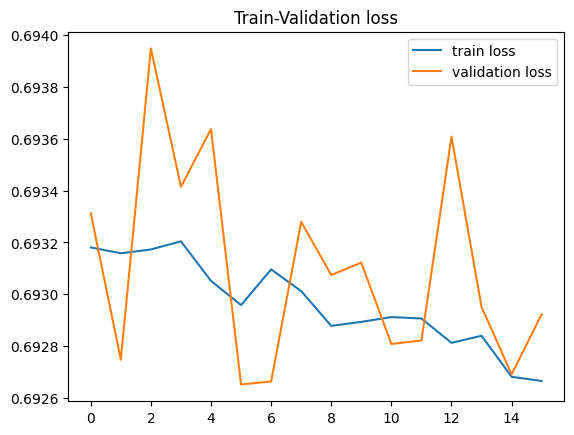

In [51]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [52]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5012755102040817, 'precision': 0.5012755102040817, 'f1': 0.5012755102040817, 'accuracy': 0.5012755102040817}
MALE {'recall': 0.4427083333333333, 'precision': 0.4427083333333333, 'f1': 0.4427083333333333, 'accuracy': 0.4427083333333333}
FEMALE {'recall': 0.5575, 'precision': 0.5575, 'f1': 0.5575, 'accuracy': 0.5575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47474747474747475, 'precision': 0.47474747474747475, 'f1': 0.47474747474747475, 'accuracy': 0.47474747474747475}
MALE {'recall': 0.38686131386861317, 'precision': 0.38686131386861317, 'f1': 0.38686131386861317, 'accuracy': 0.38686131386861317}
FEMALE {'recall': 0.5695538057742782, 'precision': 0.5695538057742782, 'f1': 0.5695538057742782, 'accuracy': 0.5695538057742782} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49674054758800523, 'precision': 0.49674054758800523, 'f1': 0.49674054758800523, 'accuracy': 0.49674054758800523}
MALE

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933323059763227 	 Validation loss: 0.6934242763761747 	 
  1%|          | 574/57400 [00:05<07:44, 122.29it/s]
Epoch 2 	 Training loss: 0.6932295175587259 	 Validation loss: 0.6926939527867204 	 
  2%|▏         | 1148/57400 [00:10<07:46, 120.45it/s]
Epoch 3 	 Training loss: 0.6932050003199627 	 Validation loss: 0.6928156230409267 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:15<07:41, 120.73it/s]
Epoch 4 	 Training loss: 0.69312223532474 	 Validation loss: 0.6923975873801668 	 
  4%|▍         | 2296/57400 [00:20<07:32, 121.75it/s]
Epoch 5 	 Training loss: 0.6931497418298954 	 Validation loss: 0.6938051833944806 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:25<07:25, 122.44it/s]
Epoch 6 	 Training loss: 0.6931147050982153 	 Validation loss: 0.6931646506665117 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:30<07:19, 122.90it/s]
Epoch 7 	 Training loss: 0.6930328425837726 	 Validation loss: 0.6931447982788086 

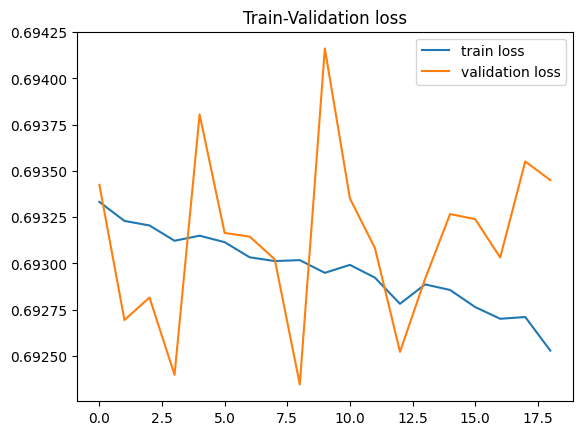

In [53]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [54]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5204081632653061, 'precision': 0.5204081632653061, 'f1': 0.5204081632653061, 'accuracy': 0.5204081632653061}
MALE {'recall': 0.17447916666666666, 'precision': 0.17447916666666666, 'f1': 0.17447916666666666, 'accuracy': 0.17447916666666666}
FEMALE {'recall': 0.8525, 'precision': 0.8525, 'f1': 0.8525, 'accuracy': 0.8525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5050505050505051, 'precision': 0.5050505050505051, 'f1': 0.5050505050505051, 'accuracy': 0.5050505050505051}
MALE {'recall': 0.19464720194647203, 'precision': 0.19464720194647203, 'f1': 0.19464720194647203, 'accuracy': 0.19464720194647203}
FEMALE {'recall': 0.8398950131233596, 'precision': 0.8398950131233596, 'f1': 0.8398950131233596, 'accuracy': 0.8398950131233596} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5149934810951761, 'precision': 0.5149934810951761, 'f1': 0.5149934810951761, 'accuracy': 0.5149934810951761}
MALE {'r

In [55]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5216836734693878, 'precision': 0.5216836734693878, 'f1': 0.5216836734693878, 'accuracy': 0.5216836734693878}
Métricas etiqueta male: {'recall': 0.4097222222222222, 'precision': 0.4097222222222222, 'f1': 0.4097222222222222, 'accuracy': 0.4097222222222222}
Métricas etiqueta female:  {'recall': 0.6291666666666667, 'precision': 0.6291666666666667, 'f1': 0.6291666666666667, 'accuracy': 0.6291666666666667}

 to
Resultado global: {'recall': 0.5134680134680134, 'precision': 0.5134680134680134, 'f1': 0.5134680134680134, 'accuracy': 0.5134680134680134}
Métricas etiqueta male: {'recall': 0.38523925385239255, 'precision': 0.38523925385239255, 'f1': 0.38523925385239255, 'accuracy': 0.38523925385239255}
Métricas etiqueta female:  {'recall': 0.6517935258092739, 'precision': 0.6517935258092739, 'f1': 0.6517935258092739, 'accuracy': 0.6517935258092739}

 as
Resultado global: {'recall': 0.5206431986093003, 'precision': 0.5206431986093003, 'f1':